# Exam Project | Face Recognizer
By **Pernille Lørup & Stephan Djurhuus**  
Institute **CPHBusiness**  

Education **Software Development**  
Elective **Artificial Intelligence**  

## The Content
## The Theory
## The Source

In [ ]:
import sys
import cv2
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

sys.path.append('../')
from FaceDetector import FaceDetector
from DataGenerator import DataGenerator
from Utilities import Displayer

In [ ]:
classes = ['dad', 'mom']
dad_path = '../data/face-data/PersonGroup/Family3-Man'
mom_path = '../data/face-data/PersonGroup/Family3-Lady'

(train_dad_data, test_dad_data) = DataGenerator.generate(dad_path, 50, label=0, test_size=.2)
(train_mom_data, test_mom_data) = DataGenerator.generate(mom_path, 50, label=1, test_size=.2)

(train_images, train_labels) = DataGenerator.merge_shuffle([train_dad_data, train_mom_data])
(test_images, test_labels) = DataGenerator.merge_shuffle([test_dad_data, test_mom_data])

In [ ]:
Displayer.images(test_images, 20)

In [ ]:
model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    Dropout(.2),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'), # softmax no go
    Dense(2, activation='relu')
])

model.summary()

In [ ]:
loss_func = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss_func, metrics=['accuracy'])

In [ ]:
train_images = np.array([image/255 for image in train_images], dtype=np.float32)
train_images = np.asarray(train_images)

test_images = np.array([image/255 for image in test_images], dtype=np.float32)
test_images = np.asarray(test_images)

train_labels = np.asarray(train_labels).astype('float32')
test_labels = np.asarray(test_labels).astype('float32')

print('train images shape', train_images.shape)
print('test images shape', test_images.shape, '\n')

history = model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

In [ ]:
# model.save('../models/sequential_model_acc82.h5')
# model = tf.keras.models.load_model('../models/sequential_model.h5')

In [ ]:
# ...
predictions = model.predict(test_images)
Displayer.conf_matrix(predictions, test_labels)

In [ ]:
image_index = 30
image = np.array([test_images[image_index]], dtype='float32')

predictions = model.predict(image)
prediction = np.argmax(predictions)

print('predictions', predictions)
print('prediction', classes[prediction])
Displayer.image(test_images[image_index])

___

In [37]:
image_path = '../data/face-data/identification3.jpg'
test_image = cv2.imread(image_path)

faceDetector = FaceDetector('FACE_DEFAULT')
test_images = faceDetector.crop_all(test_image)

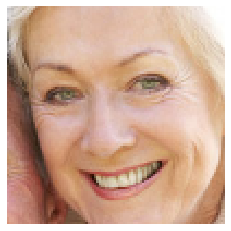

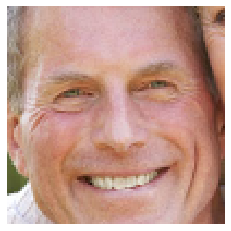

In [38]:
for image in test_images:
    Displayer.image(image)

In [ ]:
images = np.array(test_images, dtype=np.float32) 
images = np.array([image/255 for image in images], dtype=np.float32)

In [39]:
predictions = model.predict(images)
print(predictions)

[[ 0.30714858 -0.2264592 ]
 [ 0.89173156 -0.18633172]]
